### Create Synthetic Datasets
---

This notebook is used to generate simple sinusoidal synthetic datasets with a specified numbers of worms, named neurons, and other characteristics of real datasets.

*Last update: 27 October, 2023*

#### Libraries and helper functions
---

In [46]:
import torch
import pickle
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from utils import NEURONS_302
from omegaconf import OmegaConf
from scipy.stats import bootstrap
from data._main import get_dataset
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data

In [48]:
def plot_signals(data, time_tensor, neuron_idx=None, yax_limit=True, suptitle=None):
    assert isinstance(data, torch.Tensor), "data must be a PyTorch tensor"
    assert isinstance(time_tensor, torch.Tensor), "time_tensor must be a PyTorch tensor"
    assert data.dim() == 2, "data must be a 2D tensor"
    assert isinstance(neuron_idx, (int, list)), "neuron_idx must be an integer or list"

    time_tensor = time_tensor.squeeze()
    assert data.size(0) == time_tensor.size(
        0
    ), "Number of rows in data and time_tensor must match"

    num_neurons = data.size(1)

    # Randomly select the column indices if not provided
    if isinstance(neuron_idx, int):
        assert (
            neuron_idx <= num_neurons
        ), "neuron_idx cannot exceed the number of neurons"
        column_indices = np.random.choice(num_neurons, neuron_idx, replace=False)
    elif isinstance(neuron_idx, list):
        assert (
            len(neuron_idx) <= num_neurons
        ), "neuron_idx cannot exceed the number of neurons"
        column_indices = np.array(neuron_idx)

    num_columns = len(column_indices)

    # Extract the selected columns from the data tensor
    selected_columns = data[:, column_indices]

    # Define the color palette using scientific colors
    colors = sns.color_palette("bright", num_columns)

    # Plotting subplots vertically
    fig, axs = plt.subplots(num_columns, 1, figsize=(15, num_columns))
    fig.tight_layout(pad=0.0)

    for i, ax in enumerate(axs):
        ax.plot(time_tensor, selected_columns[:, i], color=colors[i])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("none")
        if yax_limit:
            ax.set_ylim(-1.0, 1.0)
        ax.set_ylabel("{}".format(NEURONS_302[column_indices[i]]))

        if i < num_columns - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel("Time")

    # Add a super title to the figure if provided
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)

    plt.tight_layout(pad=1)

    plt.show()

# Sines Dataset
---

In [64]:
def create_synthetic_dataset_sines(
    max_timesteps,
    num_worms=1,
    num_signal=302,
    num_named_neurons=302,
    if_noise=False,
    sum_frequencies=1,
    freq_gain=1.0,
    delta_seconds=0.10,
    noise_sd=0.01,
    transform=StandardScaler(),
    dataset_name="Synthetic0000",
):
    """
    Create synthetic worm datasets using a sum of sinusoidal functions.

    :param seq_len: The sequence length of the synthetic data.
    :param num_worms: The number of worms to create datasets for.
    :param num_signal: The number of signals, corresponds to number of neurons.
    :param num_named_neurons: The number of named neurons to create non-zero signals for.
    :param if_noise: If true, add Gaussian noise to the synthetic data.
    :param sum_frequencies: The number of sine functions to add together to create a signal.
    :param freq_gain: A multiplier for the frequencies of the calcium signal.
    :param delta_seconds: The constant time difference (in seconds) between each timepoint.
    :param transform: Standard deviation of the Gaussian noise.
    :param noise_sd: The sklearn transform to use for normalizing the data.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    dataset = {}
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(
        -1, 1
    )  # Column vector

    # Create a memo of neurons to frequencies so that distinct neurons have distinct frequency signatures
    neuron_to_frequencies = dict()  # this will be consistent across worms

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Create a memo of neurons to phases so that distinct neurons have distinct phase signatures
        neuron_to_phases = dict()  # this will vary across worms

        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        num_unknown_neurons = num_signal - num_named_neurons
        calcium_data = np.zeros((max_timesteps, num_signal))
        time_points = np.arange(max_timesteps)
        named_neuron_indices = random.sample(
            range(num_signal), num_named_neurons
        )  # random sampling without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        for i in named_neuron_indices:
            # TODO: Give each particular neuron a characteristic frequency that is consistent across worms
            neuron_name = NEURONS_302[i]

            frequencies = neuron_to_frequencies.setdefault(
                neuron_name,
                np.clip(np.arange(1, sum_frequencies + 1) / 100, 0, 0.1).tolist(),
                # [freq_gain * np.random.uniform(0, 0.025) for _ in range(sum_frequencies)], #! Modify here!
            )

            phases = neuron_to_phases.setdefault(
                neuron_name,
                [
                    np.random.random() * 2 * np.pi  # random phase
                    # 0.5 * 2 * np.pi  # deterministic phase
                    for _ in range(sum_frequencies)
                ],
            )

            # Add sine functions
            for freq, phase in zip(frequencies, phases):
                calcium_data[:, i] += np.sin(2 * np.pi * freq * time_points + phase)

            # Add noise
            if if_noise:
                calcium_data[:, i] += np.random.normal(0, noise_sd, max_timesteps)

        # Normalize data
        calcium_data = transform.fit_transform(calcium_data)

        # Smooth the data
        smooth_method = "FFT"
        smooth_calcium_data = smooth_data_preprocess(
            calcium_data, time_in_seconds, smooth_method
        )
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = np.finfo(float).eps
        original_dt = np.median(dt).item()
        resample_dt = delta_seconds
        residual_calcium = np.gradient(calcium_data, axis=0) / dt
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )

        # Save the data
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["original_median_dt"] = original_dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["max_timesteps"] = max_timesteps
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signal
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        worm_data = reshape_calcium_data(worm_data)

        dataset[worm] = worm_data

    return dataset


def save_synthetic_dataset(file_name, datasets):
    with open(file_name, "wb") as f:
        pickle.dump(datasets, f)

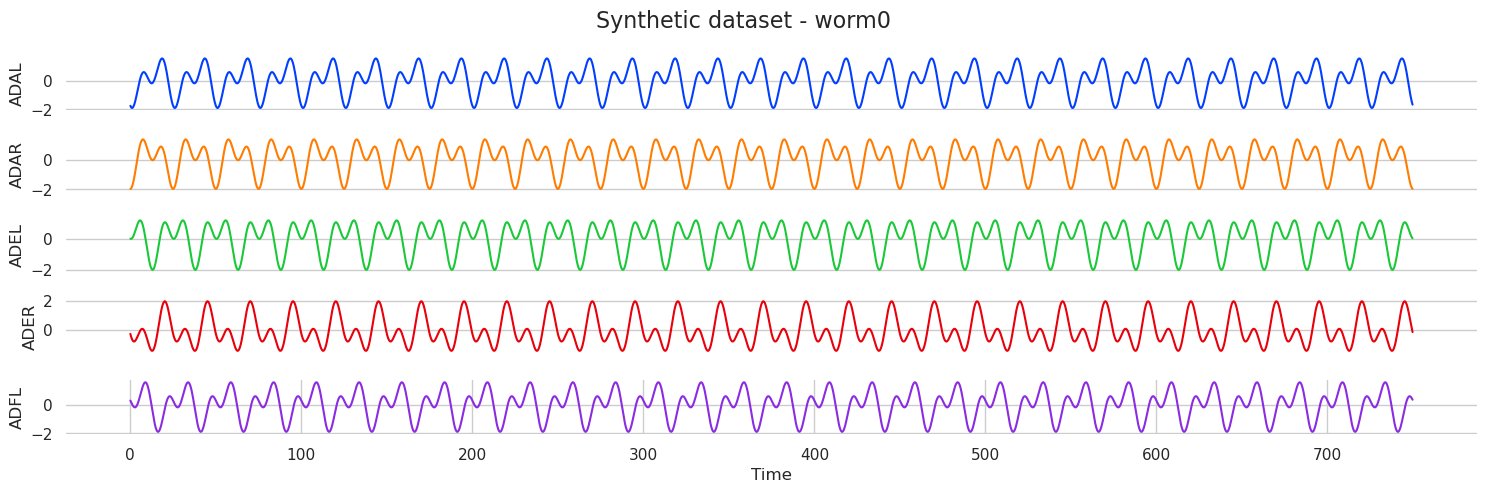

In [65]:
max_timesteps = 3000
num_worms = 1
num_named_neurons = 201
file_name = "Synthetic_sines"
sum_frequencies = 2
delta_seconds = 0.25

# Creating and saving datasets
dataset = create_synthetic_dataset_sines(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signal=302,
    num_named_neurons=num_named_neurons,
    if_noise=False,
    sum_frequencies=sum_frequencies,
    freq_gain=1.0,
    delta_seconds=delta_seconds,
    noise_sd=0.00,
    transform=StandardScaler(),
    dataset_name=file_name,
)

save_synthetic_dataset(f"processed/neural/{file_name}.pickle", dataset)

# Plotting dataset
worm_idx = "worm0"

neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()]
neuron_idx = neuron_idx[:5]

plot_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle="Synthetic dataset - {}".format(worm_idx),
)